# MSCA 31008 - Data Mining Assignment 2 (Group 4)
<b>Prinu Mathew, Qingwei Zhang, Jake Brewer</b><br>
<b>Winter 2023</b>

### Import Libraries  

In [1]:
import sys, os, json, subprocess

## for data
import pandas as pd
import numpy as np
import datetime
import random

## for machine learning
from scipy import stats
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

In [3]:
## for machine learning
try:
    from kneed import KneeLocator
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.cluster import KMeans
    from sklearn.mixture import GaussianMixture
    from sklearn.metrics import silhouette_score
    import sklearn.datasets
        
    print("~~~ Already installed required packages for machine learning ~~~~")
except Exception as e:
    print(e)
    
    print("~~~ Installing required packages for machine learning ~~~~")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "kneed"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "scikit-learn"])
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.cluster import KMeans
    from sklearn.mixture import GaussianMixture
    from sklearn.metrics import silhouette_score
    import sklearn.datasets

No module named 'kneed'
~~~ Installing required packages for machine learning ~~~~


In [ ]:
## for interactive visualization
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("~~~ Already installed required packages for interactive visualizations ~~~~")
except Exception as e:
    print(e)
    
    print("~~~ Installing required packages for interactive visualizations ~~~~")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "matplotlib"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "seaborn"])
    import matplotlib.pyplot as plt
    import seaborn as sns
    
%matplotlib inline

~~~ Already installed required packages for interactive visualizations ~~~~


## Functions

In [ ]:
# function that returns the data point allocation to specific clusters based on feature weighting technique
def get_cluster_feature_weights(n_clusters, centroids, ordered_feature_names):
    labels = n_clusters
    centroids = np.vectorize(lambda x: np.abs(x))(centroids)
    sorted_centroid_features_idx = centroids.argsort(axis=1)[:,::-1]

    cluster_feature_weights = {}
    for label, centroid in zip(range(labels), sorted_centroid_features_idx):
        ordered_cluster_feature_weights = centroids[label][sorted_centroid_features_idx[label]]
        ordered_cluster_features = [ordered_feature_names[feature] for feature in centroid]
        cluster_feature_weights[label] = list(zip(ordered_cluster_features, 
                                                  ordered_cluster_feature_weights))
    
    return cluster_feature_weights

# function that returns the count of data points allocated to specific cluster based on cluster label
def get_feature_count_by_cluster(n_clusters, df, ordered_feature_names):
    cluster_feature_weights = {}
    for index, row in df.iterrows():
        label = int(row['Cluster'])
        if(label in range(0, n_clusters)):
            if(label in cluster_feature_weights):
                weight_matrix = cluster_feature_weights[label]
            else:
                weight_matrix = []
            for row_col in row.keys():
                if(row_col in ordered_feature_names):
                    weight_matrix_item_exist = False
                    for weight_matrix_item in weight_matrix:                    
                        if(row_col in weight_matrix_item):
                            weight_matrix_item[row_col] = int(weight_matrix_item[row_col]) + 1
                            weight_matrix_item_exist = True
                            break
                    
                    if(weight_matrix_item_exist == False):
                        weight_matrix.append({row_col : 1})

            cluster_feature_weights[label] = weight_matrix

    # convert dict to tuple for immutability
    final_cluster_feature_weights = {}
    for label in range(0, n_clusters):
        final_weight_matrix = []
        for item in cluster_feature_weights[label]:
            final_weight_matrix.append([(k, v) for k, v in item.items()][0])

        final_cluster_feature_weights[label] = final_weight_matrix

    return final_cluster_feature_weights

## 1. Read dataset
Include all variables except for MEDV (Median value of owner-occupied homes in $1000's). Since MEDV typically would be the target variable that we want to predict we should exclude it so that the clusters only consist of predictor (independent) variables.

    CRIM - per capita crime rate by town
    ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
    INDUS - proportion of non-retail business acres per town
    CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
    NOX - nitric oxides concentration (parts per 10 million)
    RM - average number of rooms per dwelling
    AGE - proportion of owner-occupied units built prior to 1940
    DIS - weighted distances to five Boston employment centres
    RAD - index of accessibility to radial highways
    TAX - full-value property-tax rate per $10,000
    PTRATIO - pupil-teacher ratio by town
    B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    LSTAT - % lower status of the population
    MEDV - Median value of owner-occupied homes in $1000's

In [ ]:
# reading the CSV file
input_df = pd.read_csv('BostonHousing.csv', quotechar='"', delimiter = ',')
input_df.head(10)
X = input_df.drop(columns=['MEDV'])
input_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## 2. Scale the Data Using MinMaxScaler

In [ ]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


In [ ]:
# split data into training and testing and scale using Min-Max scaling
X_train, X_test = train_test_split(X, test_size=.3, random_state=42)

scaler  = MinMaxScaler(feature_range=(0, 1))
model=scaler.fit(X_train) # fit just to train data
X_train = model.transform(X_train) # transform train using fitted train
X_test = model.transform(X_test) # transform test using fitted train

## 3. Generate K-means Solutions with 2-10 Clusters
<b>Distortion</b>: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.<br>
<b>Inertia</b>: It is the sum of squared distances of samples to their closest cluster center.

In [ ]:
min_clusters = 2
max_clusters = 11
kmean_random_state = 50 #Determines random number generation for centroid initialization
kmean_n_init= 100       #The number of initializations to perform. The best results are kept.

In [ ]:
# run kmeans with various number of clusters
distortions = []
wcss = []
clus_size = []
centroids = []
distortions_mapping = {}
wcss_mapping = {}

kmeans_kwargs = {
    "init": "random",
    "n_init": kmean_n_init,
    "max_iter": 300,
    "random_state": kmean_random_state,
}
K = range(min_clusters, max_clusters)

# inertia or WCSS (Within Cluster Sum of Squares) measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, 
# squaring this distance, and summing these squares across one cluster. A good model is one with low inertia AND a low number of clusters ( K )
for i in K:
    kmeans = KMeans(n_clusters=i, **kmeans_kwargs)
    kmeans.fit(X_train)
    kmeans.transform(X_train)

    # calcuate distortion
    distortion = sum(np.min(cdist(X_train, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_train.shape[0]
    distortions.append(distortion)
    distortions_mapping[i] = distortion

    # get WCSS (Within Cluster Sum of Squares)
    wcss.append(kmeans.inertia_)
    wcss_mapping[i] = kmeans.inertia_

    # get cluster sizes
    clust_size_dict = {}
    for j in range(0, i):
        # percentage of data points allocated in each cluster
        clust_size_dict[j] = len(kmeans.predict(X_train)[kmeans.predict(X_train) == j]) / len(X_train)
    clus_size.append(clust_size_dict)

    centroids.append(kmeans.cluster_centers_)

## 4-5. Perform Scree Tests / Show Scree Plot

### Using the different values of Distortion:

In [ ]:
for key, val in distortions_mapping.items():
    print(f'{key} : {val}')

2 : 0.6212831415815804
3 : 0.5452062478547116
4 : 0.5029244986424605
5 : 0.47740641972605347
6 : 0.44248003460395585
7 : 0.41839266207783443
8 : 0.3985301865434334
9 : 0.3796627288482289
10 : 0.3637197037648792


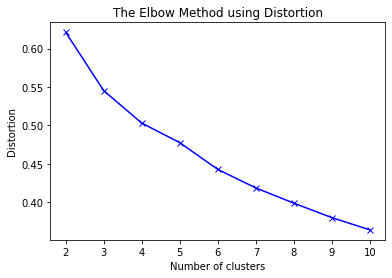

In [ ]:
# scree plot
fig, ax = plt.subplots()

ax.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

### Using the different values of Inertia (WCSS):

In [ ]:
for key, val in wcss_mapping.items():
    print(f'{key} : {val}')

2 : 159.43676200652988
3 : 123.34830485288819
4 : 105.74002956819979
5 : 92.02758267951899
6 : 81.25565416732908
7 : 72.95295871321403
8 : 65.21324206546267
9 : 59.4893519362142
10 : 54.83007242719031


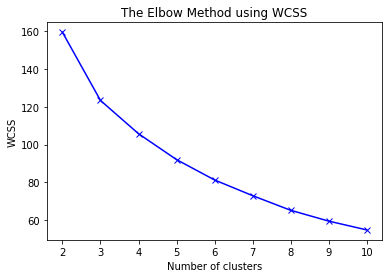

In [ ]:
# scree plot
fig, ax = plt.subplots()

ax.plot(K, wcss, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('The Elbow Method using WCSS')
plt.show()

### Identify the elbow point programmatically

In [ ]:
kl = KneeLocator(
    range(min_clusters, max_clusters), wcss, curve="convex", direction="decreasing"
)
kl.elbow

5

Even though programmatically, elbow value is 4 but through human eye, we feel comfortable with elbow value of 3. Must choose K manually and is one the of disadvantages of K-Means

In [ ]:

optimal_clusters = 3
optimal_clusters

3

### Interpretation of Scree Plot
 
From above visual interpretation, to determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. In other words, there’s a sweet spot where the SSE (sum of the squared error) curve starts to bend known as the elbow point. The x-value of this point is thought to be a reasonable trade-off between error and number of clusters. In above example, the elbow is located at x=3. Thus for the given data, we conclude that the optimal number of clusters for the data is 3

## 6. Run K-means on Test Data and Compare Results to K-means on Train Data

In [ ]:
# find the initial centroids (centers of the clusters) from the train centroids based on the optimal clusters
train_centroids = []

for j in range(len(centroids)):
    if(len(centroids[j]) == optimal_clusters):
        train_centroids = centroids[j]

if(len(train_centroids) == 0):
    raise Exception(f"Unable to find the centers of the clusters from the train data solution as a starting point from optimal clustes '{optimal_clusters}'")

train_centroids

array([[0.00100136, 0.31852803, 0.14335665, 0.04065041, 0.12228245,
        0.5506613 , 0.35396415, 0.44435102, 0.13997879, 0.20370198,
        0.5256876 , 0.98266869, 0.15832795],
       [0.00779688, 0.02402746, 0.39475956, 0.0942029 , 0.40165205,
        0.49775697, 0.83054225, 0.16238852, 0.16131065, 0.2777409 ,
        0.53630897, 0.93648247, 0.30705122],
       [0.13517724, 0.        , 0.64835913, 0.08602151, 0.5914421 ,
        0.43955467, 0.88279459, 0.08386254, 0.97194951, 0.91689239,
        0.80816747, 0.76013843, 0.45791201]])

In [ ]:
# run K-Means on the test data using the train data for fitting
# init = if an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.
test_cluster = KMeans(n_clusters=optimal_clusters, n_init=kmean_n_init, init=train_centroids, random_state=kmean_random_state) 
test_cluster.fit(X_test)
test_centroids = test_cluster.cluster_centers_

In [ ]:
test_clust_size = {}
for j in range(0, optimal_clusters):
    # percentage of data points allocated in each cluster
    test_clust_size[j] = len(test_cluster.predict(X_test)[test_cluster.predict(X_test) == j]) / len(X_test)

### Compare Train Results to Test Results

In [ ]:
# cluster sizes
print(f'Train Cluster Size : {clus_size[optimal_clusters-2]}')
print(f'Test Cluster Size : {test_clust_size}')

Train Cluster Size : {0: 0.3474576271186441, 1: 0.3898305084745763, 2: 0.2627118644067797}
Test Cluster Size : {0: 0.3618421052631579, 1: 0.34868421052631576, 2: 0.2894736842105263}


In [ ]:
# centroids - with reverse scaling (train)
train_centroids_unscale = pd.DataFrame(scaler.inverse_transform(train_centroids))
train_centroids_unscale.columns = X.columns
train_centroids_unscale

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.098149,30.260163,5.013252,0.040650,0.444429,6.570602,37.269919,6.016084,4.219512,293.739837,17.541463,390.026748,7.467805
1,0.702726,2.282609,11.682971,0.094203,0.580203,6.310471,83.545652,2.915370,4.710145,332.536232,17.641304,371.710217,12.857536
2,12.035392,0.000000,18.410968,0.086022,0.672441,6.024290,88.619355,2.051828,23.354839,667.451613,20.196774,301.775699,18.324731


In [ ]:
# centroids - with reverse scaling (test)
test_centroids_unscale = pd.DataFrame(scaler.inverse_transform(test_centroids))
test_centroids_unscale.columns = X.columns
test_centroids_unscale

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.099476,3.018182e+01,5.339818,1.818182e-02,0.447889,6.44080,34.763636,5.875256,4.290909,286.763636,17.872727,389.869091,7.129636
1,0.546002,1.000000e+00,11.032830,1.509434e-01,0.556698,6.11134,82.033962,3.271523,4.509434,326.584906,18.801887,375.332264,14.321321
2,12.856675,3.955170e-15,18.538182,4.857226e-17,0.665159,5.96800,92.818182,2.060055,23.090909,668.045455,20.195455,268.345682,19.413864


In [ ]:
# centroids - with reverse scaling (train - test)
abs(train_centroids_unscale - test_centroids_unscale)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.001327,7.834442e-02,0.326566,0.022469,0.003460,0.129802,2.506282,0.140827,0.071397,6.976201,0.331264,0.157657,0.338169
1,0.156724,1.282609e+00,0.650141,0.056740,0.023505,0.199131,1.511690,0.356152,0.200711,5.951326,1.160582,3.622047,1.463785
2,0.821282,3.955170e-15,0.127214,0.086022,0.007282,0.056290,4.198827,0.008227,0.263930,0.593842,0.001320,33.430017,1.089132


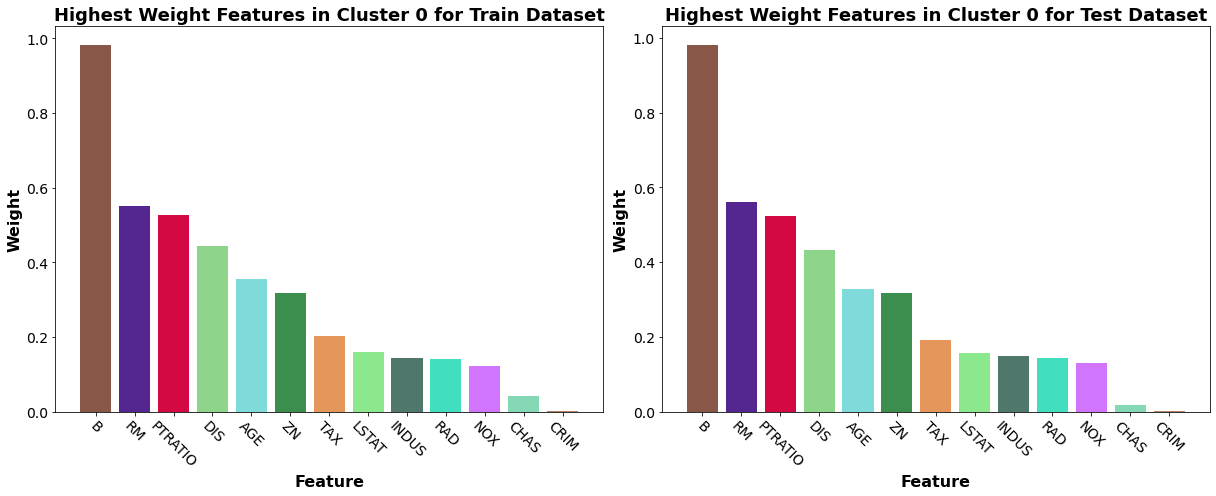

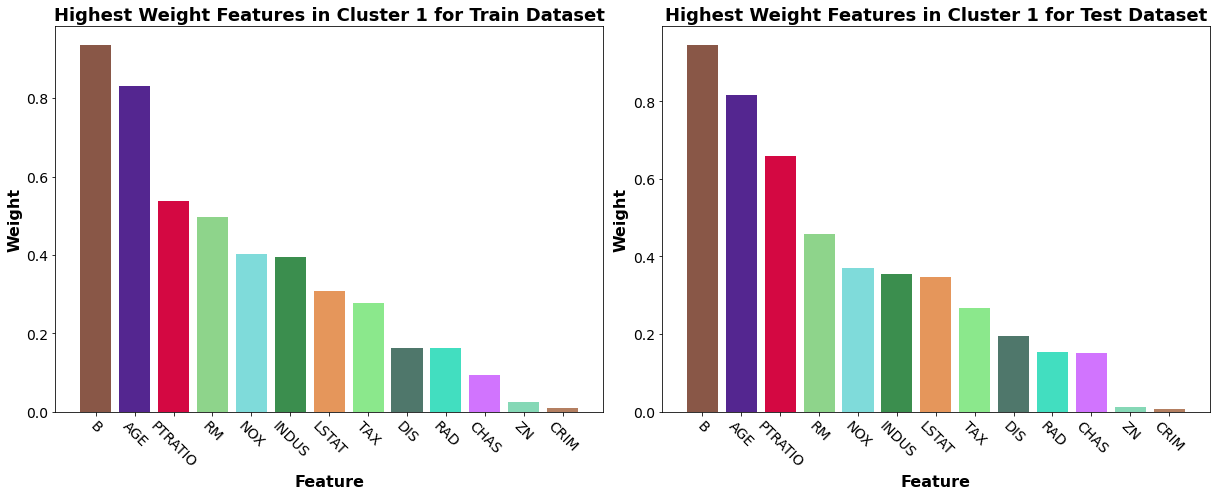

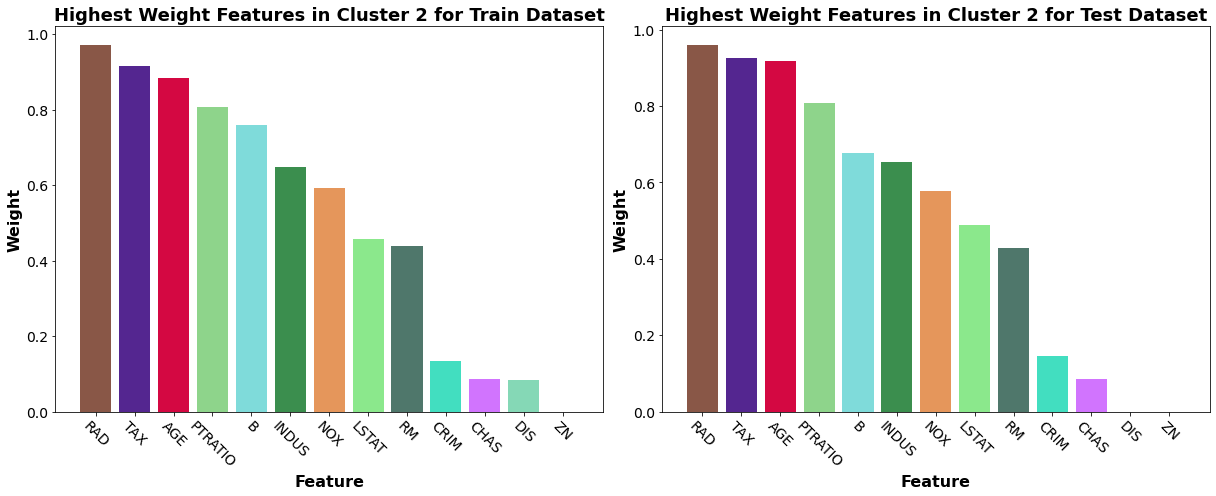

In [ ]:
# distribution of features in clusters - train versus test
no_of_features = len(X.columns)
number_of_colors = no_of_features
train_feature_importances = get_cluster_feature_weights(optimal_clusters, train_centroids, X.columns)
test_feature_importances = get_cluster_feature_weights(test_cluster.n_clusters, test_cluster.cluster_centers_, X.columns)

random.seed(no_of_features)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) 
             for i in range(number_of_colors)]

for j in range(0, optimal_clusters):
    cluster_label = j

    train_feature_weights = train_feature_importances[j]
    df_feature_weight = pd.DataFrame(train_feature_weights[:no_of_features], columns=["Feature", "Weight"])
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17,7))
    ax0.tick_params(axis='both', which='major', labelsize=14)
    ax0.bar(df_feature_weight["Feature"], df_feature_weight["Weight"], color = colors)
    ax0.set_xlabel('Feature', fontsize=16, fontweight='bold')
    ax0.set_ylabel('Weight', fontsize=16, fontweight='bold')    
    ax0.set_xticklabels(ax0.get_xticklabels(), rotation = -45)
    ax0.set_title(f'Highest Weight Features in Cluster {cluster_label} for Train Dataset', fontsize=18, fontweight='bold')

    test_feature_weights = test_feature_importances[j]
    df_feature_weight = pd.DataFrame(test_feature_weights[:no_of_features], columns=["Feature", "Weight"])
    
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.bar(df_feature_weight["Feature"], df_feature_weight["Weight"], color = colors)
    ax1.set_xlabel('Feature', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Weight', fontsize=16, fontweight='bold')
    ax1.set_xticklabels(ax0.get_xticklabels(), rotation = -45)
    ax1.set_title(f'Highest Weight Features in Cluster {cluster_label} for Test Dataset', fontsize=18, fontweight='bold')    
    
    fig.tight_layout()
    plt.show()

### Interpretation of K-means Train/Test Clustering Results
After comparing the results of the k-means clustering on the train and test data with 3 clusters we noticed the following:
- The % of data points in each cluster for both training and testing are very similar
- The cluster sizes for both training and testing are very similar
- The unscaled centroids for the training and testing sets are very similar

## 7. Generate Gaussian Mixture Models

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This works fine for when your data is circular. In contrast, Gaussian mixture models can handle even very oblong clusters. The second difference between k-means and Gaussian mixture models is that the former performs hard classification whereas the latter performs soft classification. In other words, k-means tells us what data point belong to which cluster but won’t provide us with the probabilities that a given data point belongs to each of the possible clusters.

In [ ]:
min_gaussian_components = 3
max_gaussian_components = 6
gm_random_state = 50 #Determines random number generation for initialization
gm_n_init= 100       #The number of initializations to perform. The best results are kept.

In [ ]:
aics = []
bics = []
n_components = range(min_gaussian_components, max_gaussian_components)
for i in n_components:
    gmm = GaussianMixture(random_state=gm_random_state, n_components=i, n_init=gm_n_init)
    gmm.fit(X_train)
    aics.append(gmm.aic(X_train))
    bics.append(gmm.bic(X_train))

## 8. Chosing Best GM Model and Interpret Results

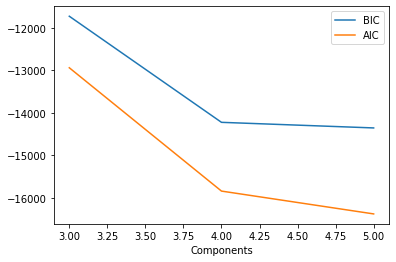

In [ ]:
# scree plot
plt.plot(n_components, bics, label='BIC')
plt.plot(n_components, aics, label='AIC')
plt.legend(loc='best')
plt.xlabel('Components');
plt.show()

The optimal number of clusters is the value that minimizes the AIC or BIC. We train our GM model using the optimal number of components (in this case, 4)

In [ ]:
# display means of gm clusters with 4 components
n_components = 4
gmm = GaussianMixture(random_state=gm_random_state, n_components=n_components, n_init=gm_n_init)
gmm.fit(X_train)
gmm_labels = gmm.predict(X_train)

gmm_means_unscale = pd.DataFrame(scaler.inverse_transform(gmm.means_))
gmm_means_unscale.columns = X.columns
gmm_means_unscale

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.095644,26.048162,5.023571,0.0,0.449595,6.508218,42.824211,5.776910,4.251352,292.446293,17.566697,390.532491,7.871638
1,13.080668,0.000000,18.100000,0.0,0.670512,5.985829,88.290244,2.075834,24.000000,666.000000,20.200000,292.285000,19.088537
2,0.770750,2.344237,13.079836,0.0,0.596508,6.268799,84.562732,2.728406,4.653891,354.158593,17.891084,366.571144,13.709807
3,2.235490,8.846154,12.967308,1.0,0.598765,6.680692,76.957692,2.933454,10.884615,414.153846,17.576923,381.737308,9.800769


In [ ]:
# display centroids of Kmeans train cluster
train_centroids_unscale

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.098149,30.260163,5.013252,0.040650,0.444429,6.570602,37.269919,6.016084,4.219512,293.739837,17.541463,390.026748,7.467805
1,0.702726,2.282609,11.682971,0.094203,0.580203,6.310471,83.545652,2.915370,4.710145,332.536232,17.641304,371.710217,12.857536
2,12.035392,0.000000,18.410968,0.086022,0.672441,6.024290,88.619355,2.051828,23.354839,667.451613,20.196774,301.775699,18.324731


In [ ]:
# distribution of features in each cluster
gmm_X_train = pd.DataFrame(X_train, columns=X.columns)
gmm_X_train["Cluster"] = gmm_labels

train_gmm_feature_importances = get_feature_count_by_cluster(n_components, gmm_X_train, X.columns)
df_feature_weight = pd.DataFrame(X.columns, columns=["Feature"])
for label in range(0, n_components):
    df_feature_weight[f"Cluster {label} Weight"] = [(v) for k, v in train_gmm_feature_importances[label]]
df_feature_weight

,Feature,Cluster 0 Weight,Cluster 1 Weight,Cluster 2 Weight,Cluster 3 Weight
0,CRIM,136,82,110,26
1,ZN,136,82,110,26
2,INDUS,136,82,110,26
3,CHAS,136,82,110,26
4,NOX,136,82,110,26
5,RM,136,82,110,26
6,AGE,136,82,110,26
7,DIS,136,82,110,26
8,RAD,136,82,110,26
9,TAX,136,82,110,26


### Compare Train GM Results to Trained K-means Results
For K-means, our scree plot indicated that 3 clusters was an optimal number of clusters, where as Gaussian Mixture shows from both the AIC and BIC plot that 4 clusters is more optimal. The above tables compare the centroids of the clusters for GM (top) and K-means (bottom)

## 9. Summarize Overall Results with Business Relevant Insights

### Interpretation of the Kmeans Clusters
The Kmeans analysis suggested that the Boston housing market could be broken down into 3 clusters, that based on common knowledge could be described as something similar to the below:
- Cluster 0: Suburban, upper class and upper middle class
- Cluster 1: City, middle class, nitric oxides concentration is higher than cluster 0 and but lower than cluster 2
- Cluster 2: Inner City, lower class, more people pays taxes but not neccessarily mean they are paying higher taxes, nitric oxides concentration is highest.

The rationale for these descriptions is as follows:
- Cluster 0: Low LSAT (lower status % of population), newer buildings (AGE), lower pupil-to-teacher ratio (i.e. higher teacher-to-pupil ratio), very low nitric oxides concentration, very low crime rate (CRIM), largest # of average rooms per dwelling across clusters, furthest distance from employment centers which tend to be in more urban areas, etc.
- Cluster 1: all of the above stats are weaker for Cluster 1, but not as weak as Cluster 2
- Cluster 2: weakest stats described above (i.e. highest LSAT, highest crime rate, highest nitric oxides concentration etc.)

### Interpretation of the Gaussian Mixture Clusters
The Gaussian Mixtures analysis suggests that the true number of clusters is 4 as oppossed to the 3 found with Kmeans. The 4 clusters could be described as something similar to the below:
- Cluster 0: Suburban, upper class and upper middle class
- Cluster 1: A nicer part of downtown Boston, middle class
- Cluster 2: Inner City, lower class
- Cluster 3: City - perhaps an area not as "developed" as cluster 1, but nicer than cluster 2, middle class

The descriptions to the GM clusters are very similar to those of the Kmeans cluster, but it would seem that the GM clusters further separate the housing area that is along the Charles River (CHAS) - Cluster 1.

### Business Insights
The analysis of the Boston Housing data clearly provides some insight into certain areas of residential living in Boston. These insights could be valuable for many businesses such as marketing companies who tailor content to certain demographics. It can be used to group similar neighborhoods based on the features of the houses like median value of owner-occupied homes, crime rate, nitric oxides concentration, and other relevant information.

## 10. Housing Development Scenario
For the following scenario we will be using the 3 clusters suggested using the K-Means approach

a. What approach will you take to attract people from different classes for selling or buying houses across boston area?
- For Cluster 0,
    - by reducing pupil-teacher ratio perphaps attract families with children as they will be looking for good public school system
	- increase accessibilities to public transportation systems
		
- For Cluster 1 and 2,</br>
    - by reducing pupil-teacher ratio perphaps attract families with children as they will be looking for affortable and good public school system
	- deploying employment centres in middle and lower class areas attract people for different kind of jobs
	- provide government incentivies, for installing electric stoves or placement of air purifiers with HEPA and carbon filters can decrease indoor nitric oxides concentrations in middle and lower class homes
    - steps to reduce crime rates in middle and lower class areas ensures safety for families and perphaps attract families	to move to those areas
	- government incentivies to build new houses by giving contracts to 3rd parties

b. How will real estate identify housing demands in each segment?
- Housing demands could likely be identified by attributes that define their segment
    - Cluster 0 are less poor which would suggest that they are more educated on average and has higher jobs and more money. More number of employment centers attracts peoples
    - Cluster 1 middle class people but can increase housing demand by improving the infrastructure, employment centers, reducing crime rates 
    - Cluster 2 lower class people but can attract housing demand by improving the infrastructure, employment centers, reducing crime rates 

Based on these descriptions we likely could identify the segment and make decisions about where to invest in real estate or which neighborhoods to target for housing development.